In [36]:
# https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf
# !conda install nglview -c conda-forge -y
# !conda install -c conda-forge kimpy openkim-models -y
# !pip install ase
# !conda install matplotlib -y
# !conda install scipy -y
# !conda install tqdm -y
# !pip install nglview scikit-learn scipy ipympl ipywidgets matplotlib
# !pip install sgdml
# !pip install sgdml[ase]
# !pip install sgdml[torch]
# !jupyter-nbextension enable nglview --py --sys-prefix
%load_ext autoreload
%autoreload 2
from utils import *
import gc
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data-Driven Force Fields for Large Scale Molecular Dynamics Simulations of Halide Perovskites  

 
## Halide Perovskites (HaPs) 


## Theoretical Research of the Dynamics of Halide Perovskite 

Many of the properties of the HaPs are based on the unique structure and dynamics of the HaPs system. Also, numerous reports show that, even without defects, HaPs shows significant structural fluctuations.6 One of the main methods of investigating the properties of HaPs theoretically is molecular dynamics (MD). By employing the MD method one can obtain extensive dynamical information - including the actual location of the atoms, energy levels and the band structure, dipoles, and much more. 

## Molecular Dynamics (MD) 

Molecular Dynamics (MD) simulation is an algorithm for computing equilibrium and transport properties of many-body systems at a finite temperature. This method relies on the Newtonian equations of motion, updated each step numerically according to calculated forces. The applied forces of all the particles/atoms in the systems are updated by various possible methods, a few of which are discussed below.7  

### Classical Potential Molecular Dynamics 

Most common MD simulations are based on classical potentials. These potentials are usually based on principles of quantum mechanics but only in the form of fitted parameters, while the implementation of the equations is classical – atoms are regarded as points in space. The potential parameters need to be determined empirically for each set of materials. They are therefore limited in accuracy and types of systems.  

### First-Principles Molecular Dynamics 

First-principles molecular dynamics are dynamical simulations, in which forces on the atoms are calculated using first-principles methods. By far the most common first-principles method is density functional theory (DFT). First-principles calculations are considered more accurate than classical potentials and inherently take into account the quantum nature of the interaction of the atoms and the electron cloud. Their critical limitation, however, is the computational cost of a meaningful simulation. While it is possible to obtain many useful insights from those simulations, for HaPs, which are highly dynamical materials, these limitations are hard to surpass.  

## Molecular Dynamics of Halide Perovskite 

HaPs are comprised of at least three or more types of atoms and have many anharmonic features. This makes the usage of classical potential MD simulation very difficult for those materials. The only current possible option for dynamical research is of use first-principles MD, which limit the scale of the simulations. 

## Data-Driven Molecular Dynamics  

Until recently, constructing MD potentials was based on benchmark data and a small set of first-principles calculations, used to fit a classical MD potential. This process is highly specialized and involved, and required much understanding of the modeled system.  

The ever-increasing processing power and the rise of shared experimental and computational results data repositories provide the opportunity to easily obtaining a vast amount of information and data for each desired system. This change of setting allows the emergence of data-driven MD potentials. Those potentials are based on statistical learning, a branch of mathematics looking to extract and predict new properties from a given dataset.8  These approaches rely on much larger amounts of data compares to the classical approach. However, obtaining the potential is more general and can be easily applied to different systems. 

The two most common approaches are the artificial neural network (ANN) and the Gaussian process (GP). The methods are mathematical, but can be enhanced by using physical insights.9,10 The ANN is considered by many as a "black box" because the model has low interpretability but, by definition, can approximate any continuous function to a desired accuracy with enough data and a large enough network.11 GP's are somewhat limited in their prediction limits, but they are much easier to understand. Thus, it is possible to add deep physical insights that can drastically decrease the needed dataset size for the same accuracy.

## Gaussian Process Force-Field 
This work proposed to use the symmetrized gradient-domain machine learning (sGDML) method, a Gaussian process-based force field. The GP method is based on jointly gaussian distributions. Each configuration of the system is considered a single gaussian distribution coupled in an approximate manner to other configurations, by using a predefined "kernel function" which is considered a hyperparameter.

# Normal/Gaussian distribution
Normal distributions are important in statistics and are often used to represent real-valued random variables whose distributions are not known. Their importance is partly due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). It states that, under some conditions, the average of many samples (observations) of a random variable with finite mean and variance is itself a random variable—whose distribution converges to a normal distribution as the number of samples increases. 

based on: https://peterroelants.github.io/posts/multivariate-normal-primer/

## Univariate normal distribution

Univariate/single normal distribution is the simple case that the for given single value-scaler we have continuous probability distribution.
$$
\mathcal{N}(\mu, \sigma^2)
$$

$$
p(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(x - \mu)^2}{2\sigma^2}\right)}
$$

In [2]:
def univariate_normal(x, mean, variance):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

In [3]:
univariate_plot(univariate_normal)

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-3.0), FloatSlider(value=1.0, desc…

## Multivariate normal distribution
multivariate normal distribution, multivariate Gaussian distribution, or joint normal distribution is a generalization of the one-dimensional (univariate) normal distribution to higher dimensions.

$$
p(\mathbf{x} \mid \mathbf{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^d \lvert\Sigma\rvert}} \exp{ \left( -\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right)}
$$

$$
\mathcal{N}(\mathbf{\mu}, \Sigma) \\
\mathbf{\mu} = \begin{pmatrix} \mu_1 \\ \mu_2\\ \dots\\ \mu_n\end{pmatrix}, 
\mathbf{\Sigma} = \begin{pmatrix}    \Sigma_{11} & \Sigma_{12} &\dots & \Sigma_{1n}
                                  \\ \Sigma_{21} & \Sigma_{22} & \dots & \Sigma_{2n}
                                  \\ \dots & \dots & \dots & \dots
                                  \\ \Sigma_{n1} & \dots & \dots &\Sigma_{nn}\end{pmatrix}, \mathbf{\Sigma} =\mathbf{\Sigma^\top}: \Sigma_{21}=\Sigma_{21}
$$

In [4]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

## 2D Multivariate normal distribution

$$
\mathcal{N}\left(
\begin{bmatrix}
0 \\
1
\end{bmatrix}, 
\begin{bmatrix}
1 & C \\
C & 1
\end{bmatrix}\right)
$$

In [5]:
plt.close('all')
multivariate_plot(multivariate_normal, nb_of_x=100)

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='C', max=0.99, step=0.01), O…

## Marginal and Conditional normal distributions

If both $\mathbf{y_1}$ and $\mathbf{y_2}$ are [jointly normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Joint_normality) the random vectors defined as:
$$
\begin{bmatrix}
\mathbf{y_1} \\
\mathbf{y_2} 
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
\mu_{\mathbf{1}} \\
\mu_{\mathbf{2}}
\end{bmatrix},
\begin{bmatrix}
\Sigma_{11} & \Sigma_{12} \\ 
\Sigma_{21} & \Sigma_{22}
\end{bmatrix}
\right)
= \mathcal{N}(\mu, \Sigma)
, \qquad 
$$

The [conditional distribution](https://en.wikipedia.org/wiki/Conditional_probability_distribution) of $\mathbf{y_1}$ given $\mathbf{y_2}$ is defined as:

$$
p(\mathbf{y_1} \mid \mathbf{y_2}) = \mathcal{N}(\mu_{1|2}, \Sigma_{1|2})
$$

With:
$$\mu_{1|2} = \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2) \;
\Sigma_{1|2} = (\Sigma/\Sigma_{22})=\Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}$$



For more details, see [Proof 1](#Proof_1)



In [6]:
plt.close('all')
condition_plot(nb_of_x=100)

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=1.0, min=-1.0), Flo…

# Gaussian Process 
Gaussian process (GP) Is a method predicting $y^*$ for a given $x^*$ and getting: $y_i=f(x_i )$. 
GP assumes that $p(f(x_1),...,f(x_N  ))$ is a jointly Gaussian, i.e., the probability of getting the full random vector (the known $y$ points and the the new $y^{*}$ points) is defined as a multidimensional gaussian with $\mu$ and $\Sigma(x)$, where $\Sigma(x)$ is calculated as $\Sigma_{ij}=k(x_i,x_j)$, and $k$ is a kernel function.


$$
\begin{pmatrix}
\mathbf{y} \\ 
y^*
\end{pmatrix}=
\begin{pmatrix}
\mathbf{f} \\ 
f^*
\end{pmatrix}~
\mathcal{N}
\begin{pmatrix}
\begin{pmatrix}
\mathbf{\mu(x, y)} \\ 
\mu^*(x^*)
\end{pmatrix},
\begin{pmatrix}
\mathbf{K(x,x)} & \mathbf{k(x^*,x)^*}\\ 
{\mathbf{k(x^*, x)^{*}}}^{\top} & {k(x^*,x^*)^{**}}
\end{pmatrix}
\end{pmatrix}
$$
<br/>
$\mathbf{f}$ - Vector of all observed $y_i$ values, $f=y_i=f(x_i)$.<br/>
$f^*$ - Prediction function for point $x^*$, $f^*=y^*=f(x^*)$.<br/>
$\mathbf{\mu}$ - Vector of all observed mean values.<br/>
$\mathbf{\mu^*}$- Mean values for the prediction for x^*. <br/>
$\mathbf{K}$ - Covariance matrix of all observed points<br/>
$\mathbf{k^*}$ - Kernel vector $k^*=k(x^*,x_i )$<br/>
${k^{**}}$ - Self kernel $k^{**}=k(x^*,x^* )$<br/>


## Applying the Conditional 
$$f(x^*)=f(x^*|\mathbf{y},\mathbf{x})=\mu(x^*)^* +{{\mathbf{k}}^{*}}^{\top}  \mathbf{K}^{-1}(\mathbf{y}-\mu)$$ <br/>
For simplicity, we can define the mean values to be zero<br/>
$$f(x^*) ={\mathbf{k^*}}^{\top}\mathbf{K}^{-1}\mathbf{y}=\sum_{i=1}^{N}\alpha_ik(x_i, x^*)$$

### The Conditional on A Nosey Dataset
If we have a training dataset with noisy function values $\mathbf{y} = \mathbf{f} + \boldsymbol\epsilon$ where noise $\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \sigma_y^2 \mathbf{I})$ is independently added to each observation then the predictive distribution is given by

$$
f(x^*) ={\mathbf{k^*}}^{\top}\mathbf{K_y}^{-1}\mathbf{y}=\sum_{i=1}^{N}\alpha_ik(x_i, x^*)
$$
where $\mathbf{K}_y = \mathbf{K} + \sigma_y^2\mathbf{I}$.

### Kernel Function
the is the kernel function which can be regarded as a "distance" function which defines how strongly the value $f(x_i)$ is coupled to point $f(x_j)$.

#### The Most Popular Kernal
In this part we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel. which is the go to kernel for starting the GP regression.
$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)\tag{10}
$$

Based on:\
https://juanitorduz.github.io/gaussian_process_reg/ \
http://krasserm.github.io/2018/03/19/gaussian-processes/

In [7]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes
    a covariance matrix from points in X1 and X2.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * sqdist)

In [8]:
plt.close('all')
n_sample = 50
n_predict = 10

x = plot_noise_sin(n_sample, plot_line=True, label='sample')
x_add = plot_noise_sin(n_predict, label='prediction')

x = np.concatenate([x, x_add], axis=0)


<IPython.core.display.Javascript object>

In [9]:
plt.close('all')
heapmap_kernal(x.reshape([-1, 1]),  kernel)

<IPython.core.display.Javascript object>

$$
f(x^*) ={\mathbf{k^*}}^{\top}\mathbf{K_y}^{-1}\mathbf{y}=\sum_{i=1}^{N}\alpha_ik(x_i, x^*)
$$

In [10]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution
    from m training data X_train and Y_train and n new inputs X_s.

    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.

    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y ** 2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) 
    K_inv = inv(K)


    alphas = K_inv.dot(Y_train)
    mu_s = K_s.T.dot(alphas)


    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

In [11]:
plt.close()
noise = 0.1
x = [-3, -2 , -1,  1, 2 , 3, 4]
def f(x):
    func = np.exp(np.sin(x))
    return func
    
gaussian_process(x, f, noise, posterior_predictive, kernel)

<IPython.core.display.Javascript object>

In [12]:
plt.close('all')
noise = 0.1
kernal = ConstantKernel(1.0) * RBF(length_scale=1.0)

gaussian_process_interactive(f, noise, kernal)

<IPython.core.display.Javascript object>

## GP Force Field 

A straightforward formulation of a vector-valued estimator
takes the form:
$$
\mathbf{\hat{f}}=\begin{bmatrix}\hat{f}_1(x), \dots, \hat{f}_N\end{bmatrix}^{T}
$$
$\mathbf{\hat{f}}: \mathbb{R}^N\rightarrow\mathbb{R}^N$ where each component: ${\hat{f}_i}: \mathbb{R}^N\rightarrow\mathbb{R}$

and it easy to applied it directly for prediction the forces on $N$ atoms system with $N$ 3D position vector and $N$ 3D forces vectors:
$\mathbf{\hat{f}}: \mathbb{R}^{3N}\rightarrow\mathbb{R}^{3N}$ where each component: ${\hat{f}_i}: \mathbb{R}^{3N}\rightarrow\mathbb{R}$

In [26]:
plt.close('all')
from ase_utils import *
from ase import Atom, Atoms
from ase.visualize import ngl
"""Demonstrates molecular dynamics with constant temperature."""


a = 3.519
atoms_type = 'Ni'
atoms = Atoms([Atom(atoms_type, (0, 0, 0)), 
               Atom(atoms_type, (0, a/2, a/2)),
               Atom(atoms_type, (a/2, 0, a/2)),
               Atom(atoms_type, (a/2, a/2, 0))])
atoms.set_cell([a, a, a])
atoms.set_pbc(True)
atoms = atoms*2
atoms_copy = atoms.copy()
lat = np.array(atoms.get_cell())

ngl.view_ngl(atoms, w=500, h=500)

In [27]:
from ase.calculators.emt import EMT
from ase.calculators.kim.kim import KIM
T = 300  # Kelvin
# Use openKIM calculator for easy of use: https://openkim.org/
# Mishin Ni99
atoms.calc = KIM("EAM_Dynamo_MishinFarkasMehl_1999_Ni__MO_400591584784_005")


In [28]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
# Set the momenta corresponding T
MaxwellBoltzmannDistribution(atoms, T * 4 * units.kB)
# Two times room temperature simulation, Langevin thermostat
dyn = Langevin(atoms, 1 * units.fs, 2*T * units.kB, 0.002)

In [29]:
from ase.io import Trajectory
# Now run the dynamics
steps = 10000
interval=100

dyn.attach(printenergy(atoms, steps, interval), interval=interval)
# We also want to save the positions of all atoms after every 10th time step.
traj = Trajectory('reference.traj', 'w', atoms)
dyn.attach(traj.write, interval=10)

dyn.run(steps)

True

In [37]:
plt.close('all')
gc.collect()
traj = Trajectory('reference.traj', 'r', atoms)
ngl.view_ngl(traj, w=500, h=500)

/home/oz/anaconda3/envs/sgdml/lib/python3.8/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


## The Vector-Valued Estimator Problem
When mapping a scalar function $\mathbb{R}^{N}\rightarrow\mathbb{R}$ each entry in the kernel function correspond to one input vector ($x_i$). In the vector output case, we have multiple outputs for each input. Because of this limitation, we need to construct our kernel function carefully.

### The Navie Approch:
We can create an independent estimator for each value in the force vector.
$$
\mathbf{\hat{f}}=\begin{bmatrix}\hat{f}_1(x), \dots, \hat{f}_N\end{bmatrix}^{T}\\
$$
$$
\hat{f}_i(x) = \mathcal{GP}\begin{bmatrix}\mathbf{\mu(x)_i}, \mathbf{k(x,x^{'})_i}\end{bmatrix}\\
$$
$$
\mathbf{\hat{f}}=\begin{bmatrix}\hat{f}_1(x) \\ \dots \\ \hat{f}_N(x)\end{bmatrix}
=\begin{bmatrix}\mathcal{GP}\begin{bmatrix}\mathbf{\mu(x)_1}, \mathbf{k(x,x^{'})_1}\end{bmatrix} \\ 
\dots
\\ \mathcal{GP}\begin{bmatrix}\mathbf{\mu(x)_N}, \mathbf{k(x,x^{'})_N}\end{bmatrix}\end{bmatrix}
$$

In [38]:
traj = Trajectory('reference.traj', 'r', atoms)
start, every = 100, 1
(x, y), (x_test, y_test) = md_dataset_split(traj, start, every)
print(f'training points: {len(x)}')
noise = 0.2
steps = 20000

training points: 452


<IPython.core.display.Javascript object>


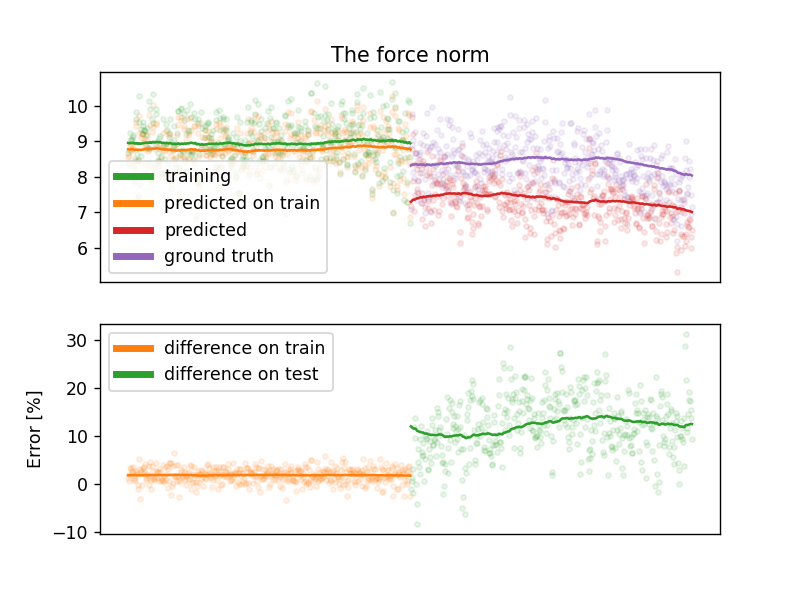

In [39]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
plt.close('all')
kernal= ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernal, alpha=noise**2)
gpr.fit(x, y)
plot_gpr(gpr, x, y, x_test, y_test)

In [43]:
gc.collect()
plt.close('all')
atoms = atoms_copy.copy()
atoms.calc = GPRCalculator(gpr)
MaxwellBoltzmannDistribution(atoms, T * 2 * units.kB)
dyn = Langevin(atoms, 1 * units.fs, T * units.kB, 0.002)
traj = Trajectory('moldyn_gdr.traj', 'w', atoms)
interval = 1
dyn.attach(printenergy_slim(steps, interval), interval=interval)
dyn.attach(traj.write, interval=10)
dyn.run(steps)
traj = Trajectory('moldyn_gdr.traj', 'r', atoms)
ngl.view_ngl(traj, w=500, h=500)

/home/oz/anaconda3/envs/sgdml/lib/python3.8/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


### Sme Tricks
##### change the kernal:
##### The Matérn kernel
It is generally assumed that overly smooth priors are detrimental to data efficiency, even if the prediction target is in fact indefinitely differentiable. For that reason, we will try to uses a Matérn kernel with restricted differentiability to construct the force field kernel function,
$$
k: C_{\mu=n+\frac{1}{2}}(d)=exp\begin{pmatrix}{-\frac{\sqrt{2\nu}d}{\sigma}}P_{n}(d)\end{pmatrix}
$$
$$
P_n(d)=\sum_{k=0}^{n}{\frac{(n+k)!}{(2n)!}}\begin{pmatrix}n\\k\end{pmatrix}\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}
$$

<IPython.core.display.Javascript object>


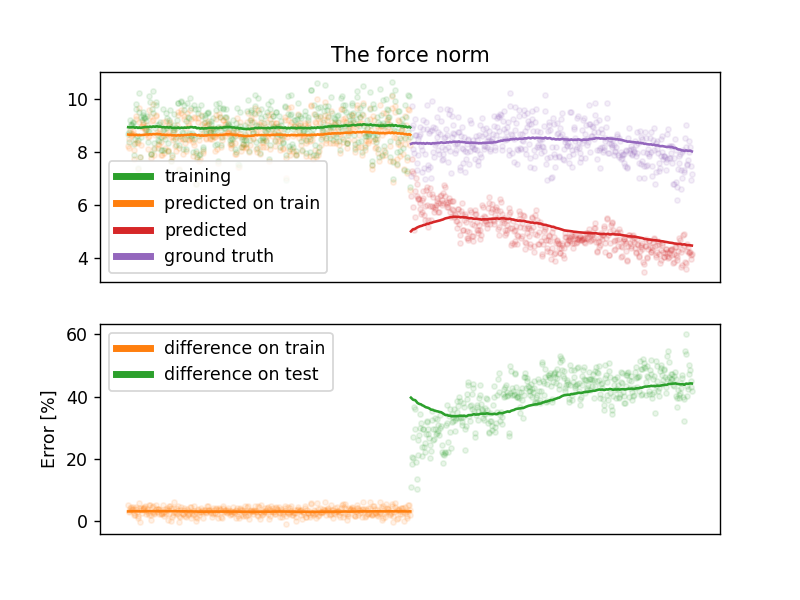

In [44]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
gc.collect()
plt.close('all')
kernal= Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernal, alpha=noise**2)
gpr.fit(x, y)
plot_gpr(gpr, x, y, x_test, y_test)

In [45]:
gc.collect()
plt.close('all')
atoms = atoms_copy.copy()
atoms.calc = GPRCalculator(gpr)
MaxwellBoltzmannDistribution(atoms, T * 2 * units.kB)
dyn = Langevin(atoms, 1 * units.fs, T * units.kB, 0.002)
traj = Trajectory('moldyn_gdr.traj', 'w', atoms)
interval = 1
dyn.attach(printenergy_slim(steps, interval), interval=interval)
dyn.attach(traj.write, interval=10)
dyn.run(steps)
traj = Trajectory('moldyn_gdr.traj', 'r', atoms)
ngl.view_ngl(traj, w=500, h=500)

/home/oz/anaconda3/envs/sgdml/lib/python3.8/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


#### Normalize y
By normalizing the output value, we can "center" our output values around zero and $\sigma=1$ for all dimensions and reduce the overexpression of a certain axis.
$$
\hat{y}_{train} = \frac{y_{train}-E[y_{train}]}{\sqrt{Var[y_{train}]}}
$$

In [46]:
gc.collect()
plt.close('all')
kernal= Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernal, alpha=noise**2, normalize_y=True)
gpr.fit(x, y)
plot_gpr(gpr, x, y, x_test, y_test)

<IPython.core.display.Javascript object>

In [47]:
gc.collect()
plt.close('all')
atoms = atoms_copy.copy()
atoms.calc = GPRCalculator(gpr)
MaxwellBoltzmannDistribution(atoms, T * 2 * units.kB)
dyn = Langevin(atoms, 1 * units.fs, T * units.kB, 0.002)
traj = Trajectory('moldyn_gdr.traj', 'w', atoms)
interval = 1
dyn.attach(printenergy_slim(steps, interval), interval=interval)
dyn.attach(traj.write, interval=10)
dyn.run(steps)
traj = Trajectory('moldyn_gdr.traj', 'r', atoms)
ngl.view_ngl(traj, w=500, h=500)

/home/oz/anaconda3/envs/sgdml/lib/python3.8/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


### Roto-translational invariance
Using cartesian coordinate values as a feature vector adds rotation and translation bias to our model. One way to manage this bias is to use a rotation-translation invariance presentation.

In this work, We use a variation of a Clolumb matrix, where the new descriptor $D$ is presented as the inverse of the distance between each atom:
$$
D_{ij}=\begin{matrix}\lVert{r_i - r_j}\lVert & i > j \\ 0 & i \leq j \end{matrix} 
$$

In [48]:
gc.collect()
plt.close('all')
d, d_test = x_to_d(x, lat), x_to_d(x_test,lat)
kernal= Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernal, alpha=noise**2, normalize_y=True)
gpr.fit(d, y)
plot_gpr(gpr, d, y, d_test, y_test)

<IPython.core.display.Javascript object>

In [50]:
gc.collect()
plt.close('all')
atoms = atoms_copy.copy()
atoms.calc = iGPRCalculator(gpr, lat)
MaxwellBoltzmannDistribution(atoms, T * 2 * units.kB)
dyn = Langevin(atoms, 1 * units.fs, T * units.kB, 0.002)
traj = Trajectory('moldyn_gdr.traj', 'w', atoms)
interval = 1
dyn.attach(printenergy_slim(steps, interval), interval=interval)
dyn.attach(traj.write, interval=10)
dyn.run(steps)
traj = Trajectory('moldyn_gdr.traj', 'r', atoms)
ngl.view_ngl(traj, w=500, h=500)

/home/oz/anaconda3/envs/sgdml/lib/python3.8/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


## Using Physical Insights to Build the Block Kernel
### Applying a Linear Operator
One way to construct the block kernel is by starting with a single-value estimator $\hat{f}$ and then applying a linear operator - $\hat{G}$ on it to obtain a vector estimator and obtain the following GP:
$$
\mathbf{\hat{g}(x)} ∼ \mathcal{GP}\begin{bmatrix}\mathbf{\hat{G}\mu(x)}, \hat{G}\mathbf{k(x,x^{'})}{\hat{G}'}^{T}\end{bmatrix}
$$

for A, B linear operators
$$
Cov[Ax,By]=ACov[x,y]B^{T}\\
E[Ax] = AE[x]
$$

### Conservative Force Field
In our case we are looking for crating an estimator for the force field. One of the most fundamental constrain on any force field is the preservation of energy i.e. the force field have to be a conservative force field. And in mathematical term we require that the curl vanishes  for every
input to the transformed energy model:
$$
\nabla\times \hat{G}\begin{bmatrix}\hat{f}\end{bmatrix} =\nabla\times \mathbf{f_F} = \mathbf{0}
$$
Not suprising the derivative operator $\nabla$ satisfied or, in the case of
energies and forces, the negative gradient operator
$$
\mathbf{\hat{f}_{F}(x)}=\hat{G}\begin{bmatrix}\hat{f}\end{bmatrix}=-\nabla\hat{f}
$$

And thank to notion that differentiation is a linear operator, the result is another GP with realizations $\mathbf{f_F}: \chi^{3N}\rightarrow \mathbb{R}^{3N}$
$$
\mathbf{\hat{f}_F(x)} ∼ \mathcal{GP}\begin{bmatrix}\mathbf{-\nabla_x\mu(x)}, \nabla_x\mathbf{k(x,x^{'})}{ \nabla_{x'}}^{T}\end{bmatrix}
$$

$$
\nabla\mathbf{k}{ \nabla}^{T}=Hess_x(k)
$$
$$
\begin{bmatrix}Hess_x(k)\end{bmatrix}_{ij}=\frac{\partial^2 k}{\partial x_i \partial x_j}
$$

## Gradient Domain Machine Learning (GDML)
This Hessian kernel gives rise to the following gradient domain machine
learning (GDML) force model as the posterior mean of the corresponding GP:<br>
he trained force field estimator collects the contributions of the
partial derivatives 3N of all training points M to compile the prediction.
It takes the form
$$
\mathbf{\hat{f}_F(x)}=\sum_i^M{\sum_j^{3N}{(\mathbf{\alpha_i})_j\frac{\partial}{\partial x_j}\nabla k(\mathbf{x}, \mathbf{x_i})}}
$$
    
Because the trained model is a (fixed) linear combination of kernel functions,
integration only affects the kernel function itself. The corresponding expression for
the energy predictor
$$
\mathbf{\hat{f}_E(x)}=\sum_i^M{\sum_j^{3N}{(\mathbf{\alpha_i})_j\frac{\partial}{\partial x_j} k(\mathbf{x}, \mathbf{x_i})}}
$$

For more details, see [Proof 2](#Proof_2)

### Roto-translational invariance
Covariance functions remain valid under any transformation of their domain $D : X → D,
i.e. k(D(x),D(x′)) = k_D(x,x′)$ is again a kernel function.
$$
D_{ij}=\begin{matrix}\lVert{r_i - r_j}\lVert & i > j \\ 0 & i \leq j \end{matrix} 
$$
And under the chain rule:
$$
\mathbf{k_F}=\nabla_x k_D \nabla_x^\top = \mathbf{J_D}^\top(\nabla_D k_D \nabla_D^\top)\mathbf{J_D}
$$
Where:
$$
\nabla_x = \begin{pmatrix}\frac{\partial}{\partial x_1} \\ \dots \\ \frac{\partial}{\partial x_{3N}}\end{pmatrix}=
\begin{pmatrix}\frac{\partial D_{11}}{\partial x_1}\frac{\partial}{\partial  D_{11}} +
                \frac{\partial D_{12}}{\partial x_1}\frac{\partial}{\partial  D_{12}} + 
                \dots
                \frac{\partial D_{1N}}{\partial x_1}\frac{\partial}{\partial  D_{1N}} +
                \frac{\partial D_{23}}{\partial x_1}\frac{\partial}{\partial  D_{23}} +
                \dots
                \frac{\partial D_{NN}}{\partial x_1}\frac{\partial}{\partial  D_{NN}}\\
                \dots \\ 
                \frac{\partial D_{11}}{\partial x_{3N}}\frac{\partial}{\partial  D_{11}} +
                \frac{\partial D_{12}}{\partial x_{3N}}\frac{\partial}{\partial  D_{12}} + 
                \dots
                \frac{\partial D_{1N}}{\partial x_{3N}}\frac{\partial}{\partial  D_{1N}} +
                \frac{\partial D_{23}}{\partial x_{3N}}\frac{\partial}{\partial  D_{23}} +
                \dots
                \frac{\partial D_{NN}}{\partial x_{3N}}\frac{\partial}{\partial  D_{NN}}\end{pmatrix}=
\begin{pmatrix}\frac{\partial D_{11}}{\partial x_1} &
               \frac{\partial D_{12}}{\partial x_1} &  
               \dots &
               \frac{\partial D_{1N}}{\partial x_1} &
               \frac{\partial D_{23}}{\partial x_1} & 
               \dots &
               \frac{\partial D_{NN}}{\partial x_1} \\
               \dots & \dots & \dots & \dots & \dots & \dots \\ 
               \frac{\partial D_{11}}{\partial x_{3N}} & 
               \frac{\partial D_{12}}{\partial x_{3N}} &  
               \dots &
               \frac{\partial D_{1N}}{\partial x_{3N}} &  
               \frac{\partial D_{23}}{\partial x_{3N}} & 
               \dots &
               \frac{\partial D_{NN}}{\partial x_{3N}} \end{pmatrix}
               \begin{pmatrix}\frac{\partial}{\partial D_{11}} \\ \dots \\ \frac{\partial}{\partial D_{NN}}\end{pmatrix}
               =\mathbf{J_D}^\top\nabla_D \\
               \\
\mathbf{J_D}=\begin{matrix}\frac{\mathbf{r_i} - \mathbf{r_j} }{\lVert{\mathbf{r_i}  - \mathbf{r_j}}\lVert^3} & i > j \\ 0 & i \leq j \end{matrix} 
$$

### The Matérn kernel
In the GDML model, a Matérn kernel functions is used
$$
k: C_{\nu=n+\frac{1}{2}}(d)=exp{-\frac{\sqrt{2\nu}d}{\sigma}}P_{n}(d)
$$
$$
P_n(d)=\sum_{k=0}^{n}{\frac{(n+k)!}{(2n)!}}\begin{pmatrix}n\\k\end{pmatrix}\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}
$$

### The Block kernel

$$
\mathbf{k_F(x, x^{'})}=\nabla k(x, x^{'})\nabla ^\top=\begin{bmatrix}\frac{\partial}{\partial x^{'}_1 }\nabla k(x,x^{'}),\dots,\frac{\partial}{\partial x^{'}_{3N} }\nabla k(x,x^{'})\end{bmatrix}
$$
$$
=\begin{pmatrix}5(\mathbf{x-x^{'}})(\mathbf{x-x^{'}})^\top-\mathbb{1}\sigma(\sigma +\sqrt{5}d))\end{pmatrix}\frac{5}{3\sigma^{4}}exp\begin{pmatrix}-\frac{\sqrt{5}d}{\sigma}\end{pmatrix}
$$
$$
\mathbf{k_F(x, x^{'})}\in \mathbb{R}^{3N \times 3N}
$$

$$
\mathbf{k_E(x, x^{'})}=k(x, x^{'})\nabla ^\top
=5(\mathbf{x-x^{'}})(\sigma+d)\frac{5}{3\sigma^{3}}exp\begin{pmatrix}-\frac{\sqrt{5}d}{\sigma}\end{pmatrix}
$$
$$
\mathbf{k_E(x, x^{'})}\in \mathbb{R}^{1 \times 3N}
$$


For more details, see [Derivation 3](#Derivation_3)


In [51]:
def block_kernal_F(x1, x2, sig=1):
    x1, x2 = x1.reshape([1, -1]), x2.reshape([1, -1])
    dim_x = x1.shape[1]
    x1, x2 = x1.reshape([dim_x, 1]), x2.reshape([dim_x, 1])
    
    d = np.linalg.norm(x1-x2)
    
    right_scalar = (5/(3*sig**4))*np.exp(-(np.sqrt(5)*d)/(sig))
    diagonal_sig = np.identity(dim_x)*sig*(sig+np.sqrt(d))
    
    x1x2 = x1-x2
    x1x2t = 5*np.matmul(x1x2, x1x2.T)
    
    return (x1x2t-diagonal_sig)*right_scalar

$$
\mathbf{k_F}=\nabla_x k_D \nabla_x^\top = \mathbf{J_D}^\top(\nabla_D k_D \nabla_D^\top)\mathbf{J_D}
$$

In [52]:
def Kf(x1, x2, sig):
    J_D1 = J_D(x1, lat)
    J_D2 = J_D(x2, lat)
    Kf = block_kernal_F(x_to_d(x1.reshape([1,-1]), lat), x_to_d(x2.reshape([1,-1]), lat) , sig)
    return J_D1.T.dot(Kf.dot(J_D2))

In [60]:
start, every = 0, 5
(x, y), (x_test, y_test) = md_dataset_split(traj, start, every)
print(f'train points: {len(x)}')
K = full_kernal(x, 1, Kf)


train points: 11


In [61]:
lam = 1e-10
K += lam*np.eye(K.shape[0])
K_inv = np.linalg.inv(K)
alpha = K_inv.dot(y.reshape([-1, 1]))

In [62]:
i = 2
x_s = x_test[i].reshape([1, -1])
k_s = k_star(x, x_s, 1, Kf)

y_s = y_test[i].flatten()
y_hat_s = k_s.T.dot(alpha).flatten()
error = np.linalg.norm(y_hat_s-y_s)/np.linalg.norm(y_s)
print(f'norm error of : {error*100} %')



norm error of : 100.00000020975057 %


In [63]:
from sgdml.cli import _print_dataset_properties, _print_model_properties, _print_task_properties
from data_utils import from_traj
dataset_path = 'reference'
dataset = from_traj(f'{dataset_path}.traj', overwrite=True)
dataset_path = f'{dataset_path}.npz'
# test = np.load('ethanol_dft.npz')
_print_dataset_properties(dataset)

[INFO] Overwriting existing dataset file.
Writing dataset to 'reference.npz'...
Number geometries found: 1,001

[DONE]
Dataset properties
  Name:              r   e   f   e   r   e   n   c   e    (32 atoms)
  Theory:            u   n   k   n   o   w   n   
  Size:              1,001 data points
  Lattice:           a     b     c    
                     7.038 0     0    
                     0     7.038 0    
                     0     0     7.038
    Lengths:         a = 7.038, b = 7.038, c = 7.038
    Angles [deg]:    alpha = 90, beta = 90, gamma = 90
  Energies [e   V   ]:
    Range:           -1.42e+02 |--   4.75   --| -1.38e+02
    Mean:            -139.914
    Variance:        0.148
  Forces [e   V   /A   n   g   ]:
    Range:           -3.79 |--   7.86   --| 4.07     
    Mean:            -0.000
    Variance:        0.790
  Fingerprint:       7017edf035cf78a7b0653d14f035006a

Example geometry (no. 518, chosen randomly)
  Copy&paste the string below into Jmol (www.jmol.org), Avog

In [64]:
n_train = 100
n_valid = 500
file = all_script(dataset_path, n_train, n_valid, use_cg=False, use_torch=True)
print(f'please run \"bash {file}\" from the terminal')

please run "bash run_me.sh" from the terminal


<IPython.core.display.Javascript object>


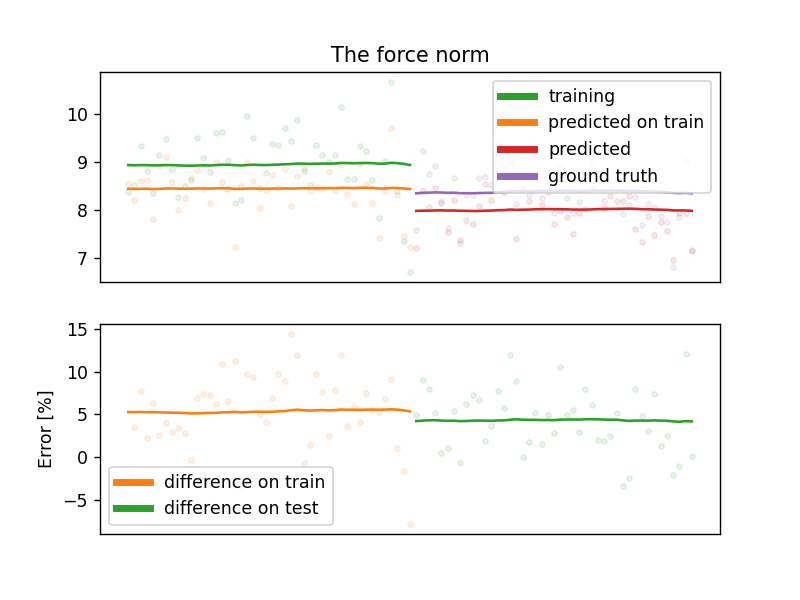

In [65]:
gc.collect()
plt.close('all')
model_path = 'reference-unknown-train100-sym1.npz'
traj = Trajectory('reference.traj', 'r', atoms)
start, every = 100, 10
plot_gdml(model_path, traj, start, every)

In [67]:
gc.collect()
plt.close('all')
from ase_utils import *
from sgdml.intf.ase_calc import SGDMLCalculator
from ase.optimize import QuasiNewton

model_path = 'reference-unknown-train100-sym1.npz'
calc = SGDMLCalculator(model_path)
atoms = atoms_copy.copy()
atoms.set_calculator(calc)
# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, T * units.kB)
dyn = Langevin(atoms, 1 * units.fs, T * units.kB, 0.002, trajectory='moldyn_sgdml.traj')   
interval = 100
dyn.attach(printenergy(atoms,steps,interval=interval), interval=interval)

# now run the dynamics
dyn.run(100)
gc.collect()



prepare


[WARN] Please remember to specify the proper conversion factors, if your model does not use
       'kcal/mol' and 'Ang' as units.


11

In [68]:
traj = Trajectory('moldyn_sgdml.traj', 'r', atoms)
ngl.view_ngl(traj, w=500, h=500)

## Proof_1
$
\begin{split}
p(x_1, x_2) = exp
\left[
-\frac{1}{2}
\begin{pmatrix}
x_1 - \mu_1 \\ 
x_2 - \mu_2
\end{pmatrix}^T
\begin{pmatrix}
\Sigma_{11} & \Sigma_{12} \\ 
\Sigma_{21} & \Sigma_{22}
\end{pmatrix}^{-1}
\begin{pmatrix}
x_1 - \mu_1 \\ 
x_2 - \mu_2
\end{pmatrix}
\right]
\end{split}
$

By using thr following idendty:

$
\begin{split}
M^{-1}=
\begin{pmatrix}
A & B \\ 
C & D
\end{pmatrix}^{-1}=
\begin{pmatrix}
I & 0 \\ 
-C^{-1}C & I
\end{pmatrix}
\begin{pmatrix}
(M/D)^{-1} & 0 \\ 
0 & D^{-1}
\end{pmatrix}
\begin{pmatrix}
I & -BD^{-1} \\ 
0 & I
\end{pmatrix}
\end{split}
$

We obtainig the folowing:

$
\begin{pmatrix}
x_1 - \mu_1 \\ 
x_2 - \mu_2
\end{pmatrix}^T
\begin{pmatrix}
\Sigma_{11} & \Sigma_{12} \\ 
\Sigma_{21} & \Sigma_{22}
\end{pmatrix}^{-1}
\begin{pmatrix}
x_1 - \mu_1 \\ 
x_2 - \mu_2
\end{pmatrix}=
\begin{pmatrix}
x_1 - \mu_1 \\ 
x_2 - \mu_2
\end{pmatrix}^T
\begin{pmatrix}
I & 0 \\ 
-\Sigma_{22}^{-1} \Sigma_{21} & I
\end{pmatrix}
\begin{pmatrix}
(\Sigma/\Sigma_{22})^{-1} & 0 \\ 
0 & \Sigma_{22}^{-1}
\end{pmatrix}
\begin{pmatrix}
I & -\Sigma_{12}\Sigma_{22}^{-1} \\ 
0 & I
\end{pmatrix}
\begin{pmatrix}
x_1 - \mu_1 \\ 
x_2 - \mu_2
\end{pmatrix}
$

And finally:

$
(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))^T(\Sigma/\Sigma_{22})^{-1}(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2)) + (x_2-\mu_2)^T\Sigma_22^{-1}(x_2-\mu_2)
$

And plugin back into the first Eq:

$
\begin{split}
p(x_1, x_2) = exp
\left[
-\frac{1}{2}
(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))^T(\Sigma/\Sigma_{22})^{-1}(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2)) + (x_2-\mu_2)^T\Sigma_22^{-1}(x_2-\mu_2)
\right]
\end{split}
$
$
\begin{split}
p(x_1, x_2) = exp
\left[
-\frac{1}{2}
(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))^T(\Sigma/\Sigma_{22})^{-1}(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))
\right] \cdot
exp
\left[
-\frac{1}{2}
(x_2-\mu_2)^T\Sigma_22^{-1}(x_2-\mu_2)
\right]
\end{split}
$

and from the axiom of probability we obtain the follwoing equlaity:

$
\begin{split}
p(x_1, x_2) = p(x_1|x_2)p(x_2)= exp
\left[
-\frac{1}{2}
(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))^T(\Sigma/\Sigma_{22})^{-1}(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))
\right] \cdot
exp
\left[
-\frac{1}{2}
(x_2-\mu_2)^T\Sigma_22^{-1}(x_2-\mu_2)
\right] = 
exp
\left[
-\frac{1}{2}
(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))^T(\Sigma/\Sigma_{22})^{-1}(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))
\right] \cdot
p(x_2)
\end{split} \\ 
\Rightarrow p(x_1|x_2) = exp
\left[
-\frac{1}{2}
(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))^T(\Sigma/\Sigma_{22})^{-1}(x_2 - \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2))
\right] \\
\mu_{1|2} = \mu_1 -\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2) \;
\Sigma_{1|2} = (\Sigma/\Sigma_{22})=\Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
$

## Proof_2

### For scalar output
$$
\begin{bmatrix}f^*\end{bmatrix}^{1\times1} = \begin{bmatrix}{k^*}^T\end{bmatrix}^{1\times M}\begin{bmatrix}\begin{bmatrix}K^{-1}\end{bmatrix}^{M \times M}\begin{bmatrix}y\end{bmatrix}^{M\times 1}\end{bmatrix}^{M\times1}=\sum_{i}^{M}\alpha_i k(x_i,x^*)
$$

### For vector output
$$
\begin{bmatrix}\mathbf{f^*}\end{bmatrix}^{3N\times1} ={k^*}^{T}K^{-1}\mathbf{f}=\sum_i^M{\sum_j^{3N}{(\mathbf{\alpha_i})_j\frac{\partial}{\partial x_j}\nabla k(\mathbf{x}, \mathbf{x_i})}}
$$

$$
K=\nabla_{x} k(x,x') \nabla_{x^{'}}^\top = 
\begin{pmatrix}
\begin{pmatrix}\nabla_{x^{(1)}} k(x^{(1)},x^{(1)}) \nabla_{x^{(1)}}^\top\end{pmatrix} & \dots & \begin{pmatrix}\nabla_{x^{(M)}} k(x^{(M)},x^{(1)}) \nabla_{x^{(1)}}^\top\end{pmatrix} \\
\dots & \dots & \dots \\
\begin{pmatrix}\nabla_{x^{(M)}} k(x^{(M)},x^{(1)}) \nabla_{x^{(1)}}^\top\end{pmatrix} & \dots & \begin{pmatrix}\nabla_{x^{(M)}} k(x^{(M)},x^{(M)}) \nabla_{x^{(M)}}^\top\end{pmatrix}
\end{pmatrix}
\\
\nabla k(x^{(i)}, x^{(j)})\nabla ^\top=\begin{bmatrix}\frac{\partial}{\partial x^{(j)}_1 }\nabla k(x^{(i)},x^{(j)}),\dots,\frac{\partial}{\partial x^{(j)}_{3N} }\nabla k(x^{(i)},x^{(j)})\end{bmatrix}^{3N\times 3N}
=\begin{bmatrix}\frac{\partial}{\partial x^{(j)}_1 }\frac{\partial}{\partial x^{(i)}_{1}} k(x^{(i)},x^{(j)}) &\dots & \frac{\partial}{\partial x^{(j)}_{3N} }\frac{\partial}{\partial x^{(i)}_{1}} k(x^{(i)},x^{(j)}) \\
\dots & \dots & \dots \\
\frac{\partial}{\partial x^{(j)}_1}\frac{\partial}{\partial x^{(i)}_{3N}} k(x^{(i)},x^{(j)}) &\dots & \frac{\partial}{\partial x^{(j)}_{3N} }\frac{\partial}{\partial x^{(i)}_{3N}} k(x^{(i)},x^{(j)})
\end{bmatrix}^{3N\times 3N}
\\
\begin{bmatrix}K\end{bmatrix}^{M\cdot3N\times M\cdot3N} \;
\begin{bmatrix}\mathbf{f}\end{bmatrix}^{M\cdot3N\times 1}
\\
$$
$$
{k^*}^{T}
=\nabla_x k(x^{*}, x)\nabla_{x^{'}} ^\top 
=
\begin{bmatrix}
\begin{pmatrix}\nabla_{x^*} k(x^{*}, x^{(1)})\nabla_{x^{(1)}} ^\top\end{pmatrix} & 
\dots & 
\begin{pmatrix}\nabla k(x^{*}, x^{(M)})\nabla_{x^{(M)}} ^\top\end{pmatrix}
\end{bmatrix}^{3N\times M\cdot 3N}
= 
\begin{bmatrix}
\begin{pmatrix}\frac{\partial}{\partial x^{(1)}_1 }\nabla k(x^{*},x^{(1)}),\dots,\frac{\partial}{\partial x^{(1)}_{3N} }\nabla k(x^{*},x^{(1)})\end{pmatrix} & 
\dots & 
\begin{pmatrix}\frac{\partial}{\partial x^{(M)}_1 }\nabla k(x^{*},x^{(M)}),\dots,\frac{\partial}{\partial x^{(M)}_{3N} }\nabla k(x^{*},x^{(M)})\end{pmatrix}
\end{bmatrix}^{3N\times M\cdot 3N}
\\
\\
\begin{bmatrix}\mathbf{f^*}\end{bmatrix}^{3N\times1} =\begin{bmatrix}\begin{bmatrix}{k^*}^{T}\end{bmatrix}^{3N \times M \cdot 3N}\begin{bmatrix}\begin{bmatrix}K^{-1}\end{bmatrix}^{M\cdot 3N \times M\cdot 3N}\begin{bmatrix}\mathbf{f}\end{bmatrix}^{M\cdot 3N \times 1}\end{bmatrix}^{M \cdot 3N \times 1}\end{bmatrix}^{3N\times 1}
\\
\begin{bmatrix}\mathbf{f^*}\end{bmatrix}^{3N\times1} =
{k^*}^{T}
K^{-1}
\mathbf{f}=
\begin{pmatrix}
\begin{pmatrix}\frac{\partial}{\partial x^{(1)}_1 }\nabla k(x^{*},x^{(1)}),\dots,\frac{\partial}{\partial x^{(1)}_{3N} }\nabla k(x^{*},x^{(1)})\end{pmatrix} & 
\dots & 
\begin{pmatrix}\frac{\partial}{\partial x^{(M)}_1 }\nabla k(x^{*},x^{(M)}),\dots,\frac{\partial}{\partial x^{(M)}_{3N} }\nabla k(x^{*},x^{(M)})\end{pmatrix}
\end{pmatrix}
\underbrace{ K^{-1}\mathbf{f}}_{\alpha _{ij}}
$$

### Derivation_3 

### Matérn covariance derivatives
$$
k: C_{\nu=n+\frac{1}{2}}(d)=B(d)P_{n}(d)
\\
B(d) = exp{\begin{pmatrix}-\frac{\sqrt{2\nu}d}{\sigma}\end{pmatrix}}
\\
P_n(d)=\sum_{k=0}^{n}{\frac{(n+k)!}{(2n)!}}\begin{pmatrix}n\\k\end{pmatrix}\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}
$$

$$
\frac{\partial \kappa}{\partial x_i} = \frac{\partial P_n}{\partial x_i}B + \frac{\partial B}{\partial x_i}P_n
$$

$$
\frac{\partial P_n}{\partial x_i}=\sum_{k=0}^n{\frac{(n+k)!}{(2n)!}\begin{pmatrix}n\\k\end{pmatrix}\frac{(n-k)(x_i -x^{'}_i)}{d^2}\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}}\\
$$

$$
\frac{\partial B}{\partial x_i} =-\frac{\sqrt{2\nu}(x_i -x^{'}_i)}{\sigma d}exp{-\frac{\sqrt{2\nu}d}{\sigma}}
$$

$$
\frac{\partial^2 \kappa}{\partial x_i \partial x_j} = 
B\frac{\partial^2 P_n}{\partial x_i \partial x_j} +
\frac{\partial B}{\partial x_i}\frac{\partial P_n}{\partial x_j} +
\frac{\partial B}{\partial x_j}\frac{\partial P_n}{\partial x_i} +
P_n\frac{\partial^2 B}{\partial x_i \partial x_j} 
$$

$$
\begin{bmatrix}\frac{\partial^2 P_n}{\partial x_i \partial x_j}\end{bmatrix}_{i\ne j}=
\sum_{k=0}^{n}{\frac{(n+k)!}{(2n)!}\begin{pmatrix}n \\ k \end{pmatrix}
\frac{(n-k-2)(n-k)(x_i -x^{'}_i)(x_j - x^{'}_j)}{d^4}
\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}}
$$

$$
\begin{bmatrix}\frac{\partial^2 P_n}{\partial x_i \partial x_j}\end{bmatrix}_{i=j}=
\sum_{k=0}^{n}{\frac{(n+k)!}{(2n)!}\begin{pmatrix}n \\ k \end{pmatrix}
\frac{(n-k-2)(n-k)(x_i -x^{'}_i)^2}{d^4}
\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}} + \sum_{k=0}^n{\frac{(n+k)!}{(2n)!}\begin{pmatrix}n\\k\end{pmatrix}\frac{(n-k)}{d^2}\begin{pmatrix}\frac{2\sqrt{2\nu}d}{\sigma}\end{pmatrix}^{n-k}}\\
$$

$$
\begin{bmatrix}\frac{\partial^2 B}{\partial x_i \partial x_j}\end{bmatrix}_{i\ne j} =
\frac{\sqrt{2\nu}(x_i-x^{'})(x_j-x^{'}_j)(\sqrt{2\nu} d+\sigma)}{\sigma^2d^3}\exp{\begin{pmatrix}-\frac{\sqrt{2\nu}d}{\sigma}\end{pmatrix}}
$$

$$
\begin{bmatrix}\frac{\partial^2 B}{\partial x_i \partial x_j}\end{bmatrix}_{i = j} =
\frac{\sqrt{2\nu}(x_i-x^{'})(x_j-x^{'}_j)(\sqrt{2\nu} d+\sigma)}{\sigma^2d^3}\exp{\begin{pmatrix}-\frac{\sqrt{2\nu}d}{\sigma}\end{pmatrix}} - \frac{\sqrt{2\nu}(x_i -x^{'}_i)}{\sigma d}exp{\begin{pmatrix}-\frac{\sqrt{2\nu}d}{\sigma}\end{pmatrix}}
$$